In [ ]:
!pip install biopython

In [ ]:
from Bio.Seq import Seq
from Bio import SeqIO
from collections import Counter
from Bio.PDB import PDBParser
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score,classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import sklearn
from sklearn.utils import shuffle

In [ ]:
df = pd.read_excel('aminoacids.xlsx')
df.head()

,amino_acids,count,location,gene
0,NFP,3,neural tissue,SNCA
1,KT,2,neural tissue,SNCA
2,MSSSISHIFSFHRDMAL,17,neural tissue,SNCA
3,D,1,neural tissue,SNCA
4,FKLQTAEKCKITVA,14,neural tissue,SNCA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310 entries, 0 to 3309
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   amino_acids  3111 non-null   object
 1   count        3310 non-null   int64 
 2   location     3310 non-null   object
 3   gene         3310 non-null   object
dtypes: int64(1), object(3)
memory usage: 103.6+ KB


In [ ]:
df.isnull().sum()

amino_acids    199
count            0
location         0
gene             0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


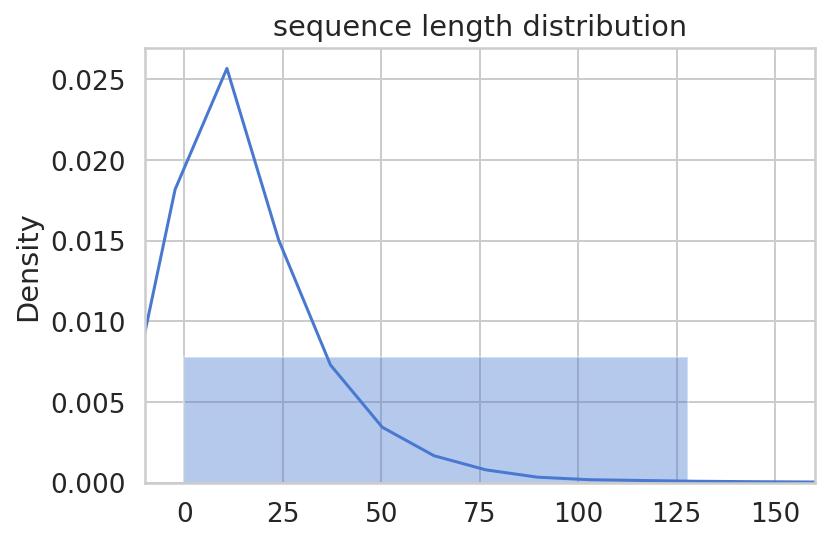

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
ax = sns.distplot(df['count'].values,bins=20)
ax.set_xlim(-10,160)
plt.title(f'sequence length distribution')
plt.grid(True) 
#mostly data covered with in the range of 40

In [ ]:
categories = df.location.astype('category').cat
df['location'] = categories.codes
class_name = categories.categories
num_classes = len(class_name)
print(class_name)

Index(['cytoplasm', 'mitochondria', 'neural tissue',
       'outer membrane of mitchondria'],
      dtype='object')


In [ ]:
df.head()

,amino_acids,count,location,gene
0,NFP,3,2,SNCA
1,KT,2,2,SNCA
2,MSSSISHIFSFHRDMAL,17,2,SNCA
3,D,1,2,SNCA
4,FKLQTAEKCKITVA,14,2,SNCA


In [ ]:
categories = df.gene.astype('category').cat
df['gene'] = categories.codes
class_name = categories.categories
num_classes = len(class_name)
print(class_name)

Index(['SNCA', 'lrrk2', 'parkin', 'pink1'], dtype='object')


In [ ]:
df.head()

,amino_acids,count,location,gene
0,NFP,3,2,0
1,KT,2,2,0
2,MSSSISHIFSFHRDMAL,17,2,0
3,D,1,2,0
4,FKLQTAEKCKITVA,14,2,0


In [ ]:
df.isnull().sum()

amino_acids    199
count            0
location         0
gene             0
dtype: int64

In [ ]:
df = df.dropna()
df.isnull().sum()

amino_acids    0
count          0
location       0
gene           0
dtype: int64

In [ ]:
df.drop(df[df['count'] <= 9].index,inplace=True)
df

,amino_acids,count,location,gene
2,MSSSISHIFSFHRDMAL,17,2,0
4,FKLQTAEKCKITVA,14,2,0
7,KSSDKDSQMLEGQLCSRRFSRSQATSNPLLCHL,33,2,0
8,FMSYVLRVHNGSKNAPHHICVSNSRMERKRRKGGIKEGSRSCHLTL...,62,2,0
9,EMLENLFVSTLHGHYQSISQQRGLCNNSKK,30,2,0
...,...,...,...,...
3294,IVYIAYHNRSIRAKYLCNNLRSFLL,25,0,1
3297,PVFIISDNSL,10,0,1
3301,YSQNLWHFTM,10,0,1
3307,KIFCILKEAML,11,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1759 entries, 2 to 3309
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   amino_acids  1759 non-null   object
 1   count        1759 non-null   int64 
 2   location     1759 non-null   int8  
 3   gene         1759 non-null   int8  
dtypes: int64(1), int8(2), object(1)
memory usage: 44.7+ KB


In [ ]:
#shuffle the data
df = sklearn.utils.shuffle(df,random_state=41)
df = df.reset_index(drop=True)
df.head()

,amino_acids,count,location,gene
0,FLPDLLDTGFICPESPSQYNEDNKVLSPLFGFCLFVVGDGGRLFCD...,106,1,3
1,FFSFQNIFLPLHKFYIYSRRNIPISDVFVCVSSWNKC,37,2,0
2,LPSLIYGEGKSSGEGTCSKSHS,22,1,3
3,FGVVHILFNLYIIWIFFSL,19,2,0
4,FVRTIPFVLQDFYISLPTLY,20,2,0


In [ ]:
#convert sequence strings into k-mer words, default size = 9
def getkmers(sequence, size=9):
  return [sequence[x:x+size].lower() for x in range(len(sequence)- size + 1)]

In [ ]:
df['words'] = df.apply(lambda x: getkmers(x['amino_acids']),axis=1)
df = df.drop('amino_acids',axis=1)
df.head()


,count,location,gene,words
0,106,1,3,"[flpdlldtg, lpdlldtgf, pdlldtgfi, dlldtgfic, l..."
1,37,2,0,"[ffsfqnifl, fsfqniflp, sfqniflpl, fqniflplh, q..."
2,22,1,3,"[lpsliygeg, psliygegk, sliygegks, liygegkss, i..."
3,19,2,0,"[fgvvhilfn, gvvhilfnl, vvhilfnly, vhilfnlyi, h..."
4,20,2,0,"[fvrtipfvl, vrtipfvlq, rtipfvlqd, tipfvlqdf, i..."


we are going to use scikit-learn nlp tools to do the k-mer counting, we need to convert thr lists of k-mers of each gene into string sentences of words that the count vectorizer can use. we can also make a y variable to hold the class labels.

In [ ]:
amino_text = list (df['words'])
for item in range(len(amino_text)):
    amino_text[item] = ' '.join(amino_text[item])
y_data = df.iloc[:,2].values

In [ ]:
print(amino_text[0])

flpdlldtg lpdlldtgf pdlldtgfi dlldtgfic lldtgficp ldtgficpe dtgficpes tgficpesp gficpesps ficpespsq icpespsqy cpespsqyn pespsqyne espsqyned spsqynedn psqynednk sqynednkv qynednkvl ynednkvls nednkvlsp ednkvlspl dnkvlsplf nkvlsplfg kvlsplfgf vlsplfgfc lsplfgfcl splfgfclf plfgfclfv lfgfclfvv fgfclfvvg gfclfvvgd fclfvvgdg clfvvgdgg lfvvgdggr fvvgdggrl vvgdggrlf vgdggrlfc gdggrlfcd dggrlfcds ggrlfcdsv grlfcdsvq rlfcdsvql lfcdsvqlh fcdsvqlhp cdsvqlhpg dsvqlhpgw svqlhpgws vqlhpgwsm qlhpgwsms lhpgwsmsg hpgwsmsgs pgwsmsgsg gwsmsgsgl wsmsgsgla smsgsglaa msgsglaae sgsglaaeg gsglaaegs sglaaegsl glaaegslq laaegslqn aaegslqne aegslqnel egslqnelv gslqnelvi slqnelviq lqnelviqw qnelviqws nelviqwsi elviqwsil lviqwsiln viqwsilnw iqwsilnww qwsilnwwg wsilnwwgp silnwwgpe ilnwwgpea lnwwgpeap nwwgpeapm wwgpeapma wgpeapmag gpeapmags peapmagss eapmagsst apmagsstp pmagsstpy magsstpyp agsstpypd gsstpypdh sstpypdhl stpypdhlg tpypdhlgi pypdhlgis ypdhlgiss pdhlgisss dhlgisssp hlgissspg lgissspgi


In [ ]:
y_data

array([3, 0, 3, ..., 0, 0, 0], dtype=int8)

we will apply the bag of words using countvectorizer using NLP

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(5,5))
x = cv.fit_transform(amino_text)

In [ ]:
print(x.shape) # 2505 rows with 41346 vectors representing proteins

(1759, 30911)


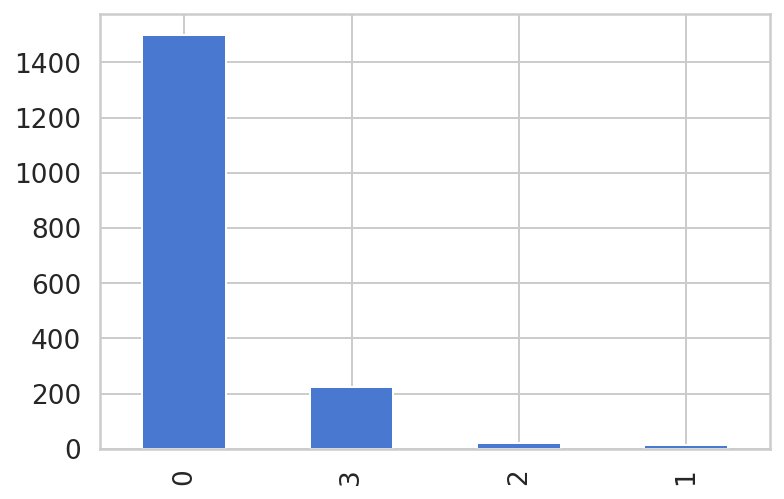

In [ ]:
df['gene'].value_counts().plot.bar()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y_data, 
                                                    test_size = 0.15, 
                                                    random_state=101)

In [ ]:
#using text processing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
pipe = Pipeline([('bow',CountVectorizer()),
                  ('tfidf',TfidfTransformer()),
                  ('model',MultinomialNB())])

x = amino_text
y = df['gene']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15,random_state=101)

pipe.fit(x_train,y_train)

pred = pipe.predict(x_test)


from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       228
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        34

    accuracy                           0.86       264
   macro avg       0.29      0.33      0.31       264
weighted avg       0.75      0.86      0.80       264

[[228   0   0]
 [  2   0   0]
 [ 34   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**latent_dirichlet_allocation_**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(5,5))
x = cv.fit_transform(amino_text)

In [ ]:
lda = LatentDirichletAllocation(n_components=4,random_state=42)

In [ ]:
lda.fit(x)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
#grab the aminoacids
len(cv.get_feature_names())

30911

In [ ]:
type(cv.get_feature_names())

list

In [ ]:
#just to check for the 5000 row
cv.get_feature_names()[5000]

'ffttnllhv fttnllhvl ttnllhvll tnllhvlln nllhvllnc'

In [ ]:
#grab the genes
len(lda.components_)

4

In [ ]:
type(lda.components_)

numpy.ndarray

In [ ]:
lda.components_.shape # this means 4 groups of genes by 41348 amino acids

(4, 30911)

In [ ]:
single_amino = lda.components_[0]

In [ ]:
single_amino.argsort()

array([10584, 18826, 13852, ...,  9602, 14182,  6329])

In [ ]:
#first argsort does sorting with the indexing location in ascending order
#top 10 values ( 10 greatest values)
#last 10 values of argsort  
single_amino.argsort()[-10:] # grab the last 10 values of  .argsort()

array([27003, 21554,  7529, 27882,  5613, 29573, 27458,  9602, 14182,
        6329])

In [ ]:
top_twenty_amino = single_amino.argsort()[-20:]

In [ ]:
for index in top_twenty_amino:
  print(cv.get_feature_names()[index])

vlfervsee lfervseeq fervseeql ervseeqlt rvseeqlte
gvhqlilkm vhqlilkml hqlilkmlt qlilkmltv lilkmltvh
dgsfgsvyr gsfgsvyra sfgsvyraa fgsvyraay gsvyraaye
getpsllki etpsllkiq tpsllkiqk psllkiqkl sllkiqkla
qhgetpsll hgetpsllk getpsllki etpsllkiq tpsllkiqk
hgetpsllk getpsllki etpsllkiq tpsllkiqk psllkiqkl
gvnfisige vnfisigew nfisigewi fisigewid isigewida
vnfisigew nfisigewi fisigewid isigewida sigewidav
ltpvipalw tpvipalwk pvipalwka vipalwkae ipalwkaev
wltpvipal ltpvipalw tpvipalwk pvipalwka vipalwkae
tpvipalwk pvipalwka vipalwkae ipalwkaev palwkaevg
rarwltpvi arwltpvip rwltpvipa wltpvipal ltpvipalw
grarwltpv rarwltpvi arwltpvip rwltpvipa wltpvipal
vflvetgfh flvetgfhh lvetgfhhv vetgfhhvg etgfhhvgq
flvetgfhh lvetgfhhv vetgfhhvg etgfhhvgq tgfhhvgqa
wlifvflve lifvflvet ifvflvetg fvflvetgf vflvetgfh
twlifvflv wlifvflve lifvflvet ifvflvetg fvflvetgf
ifvflvetg fvflvetgf vflvetgfh flvetgfhh lvetgfhhv
lifvflvet ifvflvetg fvflvetgf vflvetgfh flvetgfhh
fvflvetgf vflvetgfh flvetgfhh lvetgfhhv vetgfhhvg


#grab the genes with the highest prob per aminoacids

In [ ]:
for index, amino in enumerate(lda.components_):
  print(f"THE TOP 15 amino for gene #  {index}")
  print([cv.get_feature_names()[index] for index in amino.argsort()[-15:]])
  print('\n')
  print('\n')

THE TOP 15 amino for gene #  0
['hgetpsllk getpsllki etpsllkiq tpsllkiqk psllkiqkl', 'gvnfisige vnfisigew nfisigewi fisigewid isigewida', 'vnfisigew nfisigewi fisigewid isigewida sigewidav', 'ltpvipalw tpvipalwk pvipalwka vipalwkae ipalwkaev', 'wltpvipal ltpvipalw tpvipalwk pvipalwka vipalwkae', 'tpvipalwk pvipalwka vipalwkae ipalwkaev palwkaevg', 'rarwltpvi arwltpvip rwltpvipa wltpvipal ltpvipalw', 'grarwltpv rarwltpvi arwltpvip rwltpvipa wltpvipal', 'vflvetgfh flvetgfhh lvetgfhhv vetgfhhvg etgfhhvgq', 'flvetgfhh lvetgfhhv vetgfhhvg etgfhhvgq tgfhhvgqa', 'wlifvflve lifvflvet ifvflvetg fvflvetgf vflvetgfh', 'twlifvflv wlifvflve lifvflvet ifvflvetg fvflvetgf', 'ifvflvetg fvflvetgf vflvetgfh flvetgfhh lvetgfhhv', 'lifvflvet ifvflvetg fvflvetgf vflvetgfh flvetgfhh', 'fvflvetgf vflvetgfh flvetgfhh lvetgfhhv vetgfhhvg']




THE TOP 15 amino for gene #  1
['ergraterr rgraterrd graterrda raterrdae aterrdaev', 'rdpklnvrr dpklnvrrk pklnvrrks klnvrrksa lnvrrksap', 'nvrrksapt vrrksaptf rrksaptfp 

In [ ]:
results = lda.transform(x)

In [ ]:
results.shape

(1759, 4)

In [ ]:
results[1].round(2) # highest prob showing

array([0.01, 0.97, 0.01, 0.01])

In [ ]:
results[0].argmax()

3

In [ ]:
df['pred_gene'] = results.argmax(axis=1)

In [ ]:
df

,count,location,gene,words,pred_gene
0,106,1,3,"[flpdlldtg, lpdlldtgf, pdlldtgfi, dlldtgfic, l...",3
1,37,2,0,"[ffsfqnifl, fsfqniflp, sfqniflpl, fqniflplh, q...",1
2,22,1,3,"[lpsliygeg, psliygegk, sliygegks, liygegkss, i...",0
3,19,2,0,"[fgvvhilfn, gvvhilfnl, vvhilfnly, vhilfnlyi, h...",2
4,20,2,0,"[fvrtipfvl, vrtipfvlq, rtipfvlqd, tipfvlqdf, i...",2
...,...,...,...,...,...
1754,45,1,3,"[eqlhpslms, qlhpslmss, lhpslmssa, hpslmssap, p...",3
1755,55,2,0,"[ellmgrhqi, llmgrhqis, lmgrhqish, mgrhqishv, g...",1
1756,44,2,0,"[cgcvpiklh, gcvpiklhl, cvpiklhls, vpiklhlsk, p...",1
1757,17,2,0,"[hlfffffgr, lfffffgra, fffffgral, ffffgrall, f...",0


In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print(accuracy_score(df['gene'],df['pred_gene']))

0.3536100056850483


In [ ]:
print(confusion_matrix(df['gene'],df['pred_gene']))

[[560 309 305 326]
 [ 10   2   1   2]
 [  7   4   5   5]
 [ 84  40  44  55]]


In [ ]:
print(classification_report(df['gene'],df['pred_gene']))

              precision    recall  f1-score   support

           0       0.85      0.37      0.52      1500
           1       0.01      0.13      0.01        15
           2       0.01      0.24      0.03        21
           3       0.14      0.25      0.18       223

    accuracy                           0.35      1759
   macro avg       0.25      0.25      0.18      1759
weighted avg       0.74      0.35      0.47      1759



In [ ]:
df.head()

,count,location,gene,words,pred_gene
0,106,1,3,"[flpdlldtg, lpdlldtgf, pdlldtgfi, dlldtgfic, l...",3
1,37,2,0,"[ffsfqnifl, fsfqniflp, sfqniflpl, fqniflplh, q...",1
2,22,1,3,"[lpsliygeg, psliygegk, sliygegks, liygegkss, i...",0
3,19,2,0,"[fgvvhilfn, gvvhilfnl, vvhilfnly, vhilfnlyi, h...",2
4,20,2,0,"[fvrtipfvl, vrtipfvlq, rtipfvlqd, tipfvlqdf, i...",2


**Probabilistic modelling

In [ ]:
!pip install pgmpy

In [ ]:
df = pd.read_excel('aminoacids.xlsx')
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import ParameterEstimator
model = BayesianModel([('gene','amino_acids')])
pe = ParameterEstimator(model,df)
print('\n',pe.state_counts('gene'))
print('\n',pe.state_counts('amino_acids'))



         gene
SNCA    2711
lrrk2     38
parkin    34
pink1    328

 gene                           SNCA lrrk2 parkin pink1
amino_acids                                           
A                               2.0   0.0    0.0   0.0
AAASIPLITPVIKDGTISNEI           1.0   0.0    0.0   0.0
AACLGLPKCWDYRHEPPCLATSLF        0.0   0.0    0.0   1.0
AAFPP                           1.0   0.0    0.0   0.0
AAIRILHSFGHLVLFFHDWCCLLLRHLPVM  1.0   0.0    0.0   0.0
...                             ...   ...    ...   ...
YWQNEVSILI                      1.0   0.0    0.0   0.0
YY                              1.0   0.0    0.0   0.0
YYDISKVGTFKR                    1.0   0.0    0.0   0.0
YYLLILKKQFPLNSSH                1.0   0.0    0.0   0.0
YYTQKDRR                        1.0   0.0    0.0   0.0

[2862 rows x 4 columns]


In [ ]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, df)
print(mle.estimate_cpd('gene'))
print(mle.estimate_cpd('amino_acids'))

+--------------+-----------+
| gene(SNCA)   | 0.871424  |
+--------------+-----------+
| gene(lrrk2)  | 0.0122147 |
+--------------+-----------+
| gene(parkin) | 0.010929  |
+--------------+-----------+
| gene(pink1)  | 0.105432  |
+--------------+-----------+


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model, df)

print(est.estimate_cpd('gene', prior_type='BDeu', equivalent_sample_size=10))

+--------------+-----------+
| gene(SNCA)   | 0.869433  |
+--------------+-----------+
| gene(lrrk2)  | 0.0129766 |
+--------------+-----------+
| gene(parkin) | 0.011695  |
+--------------+-----------+
| gene(pink1)  | 0.105896  |
+--------------+-----------+


In [ ]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore
bdeu = BDeuScore(df, equivalent_sample_size=5)
k2 = K2Score(df)
bic = BicScore(df)
k2, bic

print(bdeu.score(model))
print(k2.score(model))
print(bic.score(model))


-44075.5129101115
-26905.53643722309
-70903.96852717259
